## Setup + Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [3]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [4]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [5]:
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4

In [7]:
#import paskages
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.utils import resample


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from keras.layers import *
from sklearn.metrics import classification_report, accuracy_score


In [21]:
# Set directories
train_dir = '/content/dataset/Testing Images'
test_dir = '/content/dataset/Training Images'


In [22]:
# Get class names
class_names = os.listdir(train_dir)
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

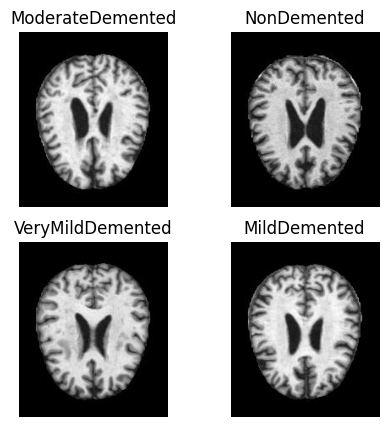

In [23]:
# Print sample images from each class
plt.figure(figsize=(5, 5))
for i, class_name in enumerate(class_names):
    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_dir, class_name)))
    img_path = os.path.join(train_dir, class_name, img_name)

    # Read and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()


In [24]:
# Function to preprocess images
def preprocess_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [25]:
# Load image paths and labels
X = []
y = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        X.append(os.path.join(class_dir, img_name))
        y.append(class_name)

In [26]:
# Split data into training and testing sets while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [27]:
# Count number of samples in each class for training and testing sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)


In [28]:
# Print the count of each class for training set before upsampling
print("Training Set Class Counts (Before Upsampling):")
for class_name, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"{class_name}: {count} samples")


Training Set Class Counts (Before Upsampling):
MildDemented: 143 samples
ModerateDemented: 10 samples
NonDemented: 512 samples
VeryMildDemented: 358 samples


In [29]:
# Print the count of each class for testing set
print("\nTesting Set Class Counts:")
for class_name, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"{class_name}: {count} samples")



Testing Set Class Counts:
MildDemented: 36 samples
ModerateDemented: 2 samples
NonDemented: 128 samples
VeryMildDemented: 90 samples


In [30]:
# Function to upsample minority classes
def upsample_minority_classes(X_train, y_train):
    df_train = pd.DataFrame({'image_path': X_train, 'class': y_train})
    class_counts = df_train['class'].value_counts()
    max_class_count = class_counts.max()

    dfs_upsampled = []
    for class_name, count in class_counts.items():
        df_class = df_train[df_train['class'] == class_name]
        if count < max_class_count:
            df_upsampled = resample(df_class, replace=True, n_samples=max_class_count, random_state=42)
            dfs_upsampled.append(df_upsampled)
        else:
            dfs_upsampled.append(df_class)

    df_train_upsampled = pd.concat(dfs_upsampled)
    X_train_upsampled = df_train_upsampled['image_path'].values
    y_train_upsampled = df_train_upsampled['class'].values
    return X_train_upsampled, y_train_upsampled

In [31]:
# Function to upsample minority classes in test data
def upsample_test_minority_classes(X_test, y_test):
    # Combine features and labels into a DataFrame
    df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

    # Separate majority and minority classes
    df_majority_test = df_test[df_test['label'].isin(['NonDemented'])]
    df_minority1_test = df_test[df_test['label'].isin(['MildDemented'])]
    df_minority2_test = df_test[df_test['label'].isin(['ModerateDemented'])]
    df_minority3_test = df_test[df_test['label'].isin(['VeryMildDemented'])]

    # Upsample minority classes
    df_minority_upsampled1_test = resample(df_minority1_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled2_test = resample(df_minority2_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled3_test = resample(df_minority3_test, replace=True, n_samples=len(df_majority_test), random_state=42)

    # Combine majority class with upsampled minority classes
    df_upsampled_test = pd.concat([df_majority_test, df_minority_upsampled1_test, df_minority_upsampled2_test, df_minority_upsampled3_test])

    # Shuffle the dataframe
    df_upsampled_test = df_upsampled_test.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    X_test_upsampled = df_upsampled_test['image_path'].values
    y_test_upsampled = df_upsampled_test['label'].values

    return X_test_upsampled, y_test_upsampled

In [32]:
# Upsample minority classes in the training set
X_train_upsampled, y_train_upsampled = upsample_minority_classes(X_train, y_train)


In [33]:
# Upsample minority classes in the test set
X_test_upsampled, y_test_upsampled = upsample_test_minority_classes(X_test, y_test)


In [34]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)

In [35]:
# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)


In [36]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train_upsampled, 'class': y_train_upsampled}),
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 2048 validated image filenames belonging to 4 classes.


In [37]:
# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test_upsampled, 'label': y_test_upsampled}),
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 512 validated image filenames belonging to 4 classes.


In [38]:
# After applying ImageDataGenerator, you can check the count of each label
train_label_counts = train_generator.classes
test_label_counts = test_generator.classes

# Count occurrences of each class label
train_label_counts = np.bincount(train_label_counts)
test_label_counts = np.bincount(test_label_counts)




In [39]:
# Print the count of each class for the training set
print("Training Set Class Counts (After Augmentation):")
for i, count in enumerate(train_label_counts):
    print(f"Class {i}: {count} samples")



Training Set Class Counts (After Augmentation):
Class 0: 512 samples
Class 1: 512 samples
Class 2: 512 samples
Class 3: 512 samples


In [40]:
# Print the count of each class for the testing set
print("\nTesting Set Class Counts:")
for i, count in enumerate(test_label_counts):
    print(f"Class {i}: {count} samples")


Testing Set Class Counts:
Class 0: 128 samples
Class 1: 128 samples
Class 2: 128 samples
Class 3: 128 samples


In [41]:
# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')
])





In [42]:
# Compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
   metrics=['accuracy'])


In [43]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_weights.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [44]:
# Train model
history = model.fit(train_generator , validation_data=test_generator , epochs=50 ,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.4164 - accuracy: 0.2524
Epoch 1: val_loss improved from inf to 1.38468, saving model to best_weights.weights.h5
32/32 [==============================] - 38s 846ms/step - loss: 1.4164 - accuracy: 0.2524 - val_loss: 1.3847 - val_accuracy: 0.2500
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.3758 - accuracy: 0.2900
Epoch 2: val_loss improved from 1.38468 to 1.33838, saving model to best_weights.weights.h5
32/32 [==============================] - 30s 900ms/step - loss: 1.3758 - accuracy: 0.2900 - val_loss: 1.3384 - val_accuracy: 0.4180
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 1.3010 - accuracy: 0.3687
Epoch 3: val_loss improved from 1.33838 to 1.32343, saving model to best_weights.weights.h5
32/32 [==============================] - 32s 972ms/step - loss: 1.3010 - accuracy: 0.3687 - val_loss: 1.3234 - val_accuracy: 0.3711
Epoch 4/50
32/32 [==============================] 

In [45]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

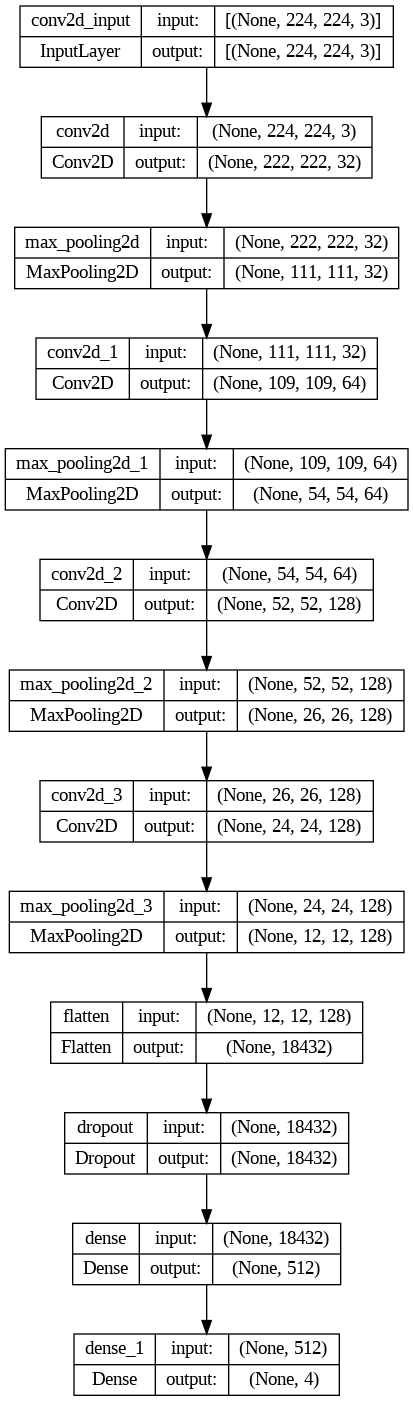

In [46]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [47]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


8/8 [==============================] - 1s 128ms/step - loss: 0.5664 - accuracy: 0.7715
Test Loss: 0.5663570761680603
Test Accuracy: 0.771484375


In [48]:
# Generate predictions
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)


8/8 [==============================] - 1s 122ms/step


In [49]:
# True classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


In [50]:
# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                  precision    recall  f1-score   support

    MildDemented       0.27      0.38      0.31       128
ModerateDemented       0.23      0.23      0.23       128
     NonDemented       0.23      0.13      0.17       128
VeryMildDemented       0.27      0.27      0.27       128

        accuracy                           0.25       512
       macro avg       0.25      0.25      0.24       512
    weighted avg       0.25      0.25      0.24       512



In [51]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes)
conf_matrix

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[48, 35, 17, 28],
       [40, 29, 19, 40],
       [49, 33, 17, 29],
       [42, 31, 20, 35]], dtype=int32)>

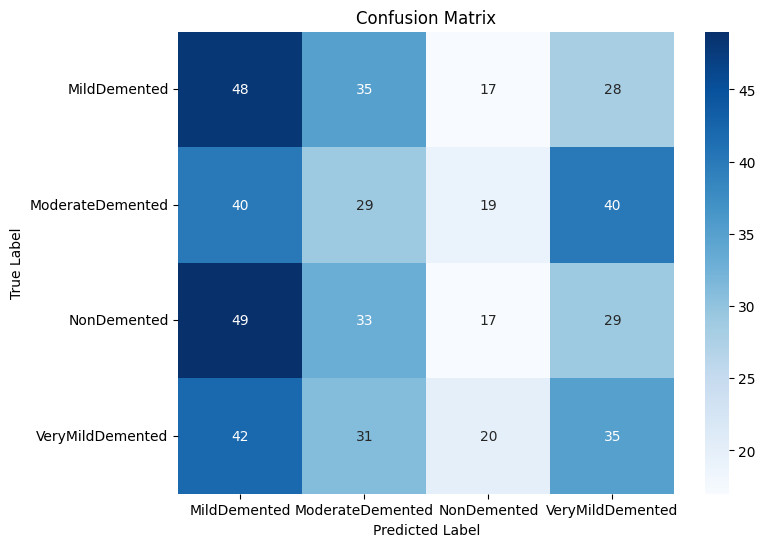

In [52]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Data Analysis

In [ ]:
#del data

In [6]:
data = pd.read_csv('dataset/Training.csv')

In [7]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [8]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


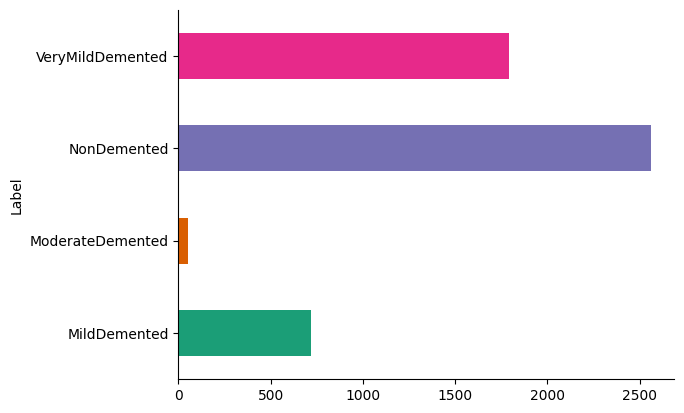

In [8]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Image path: dataset/Training Images/moderateDem51.jpg
Label: ModerateDemented
Image path: dataset/Training Images/nonDem1154.jpg
Label: NonDemented
Image path: dataset/Training Images/mildDem351.jpg
Label: MildDemented
Image path: dataset/Training Images/verymildDem80.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem711.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem446.jpg
Label: VeryMildDemented


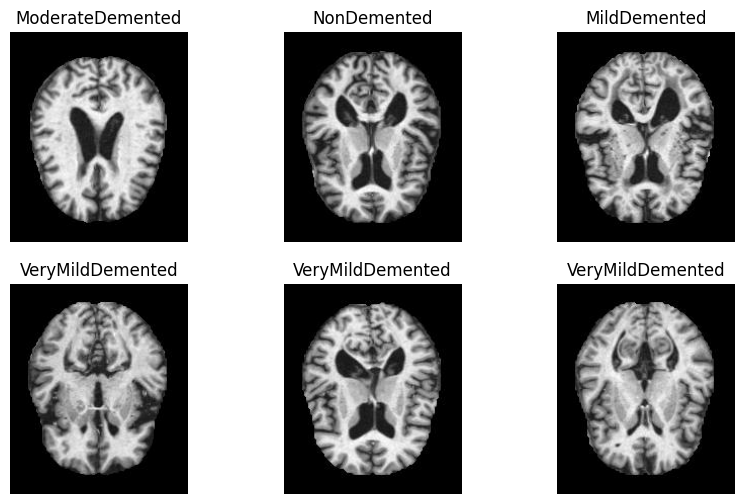

In [9]:
# Plotting random samples
plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  # Ensure this is the correct column name for the image paths
    label = data.loc[idx, 'Label']    # Ensure this is the correct column name for the labels

    print("Image path:", im_path)
    print("Label:", label)


    # Read the image using cv2
    img = cv2.imread(im_path)
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Training Setup

In [10]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [11]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [12]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [13]:
image_counts = data['Label'].value_counts()

# Print the number of images for each label
print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [14]:
data_limited = pd.DataFrame()  # Create an empty DataFrame to hold the limited set
for label in [2, 3]:
    data_subset = data[data['Label'] == label]
    # Sample 1000 images without replacement
    data_subset_sampled = data_subset.sample(n=1000, random_state=42)
    data_limited = pd.concat([data_limited, data_subset_sampled])

# For labels not in [2, 3], just append them as they are
data_other_labels = data[~data['Label'].isin([2, 3])]
data_limited = pd.concat([data_limited, data_other_labels])

In [15]:
data_limited

,Image,Label
2925,dataset/Training Images/nonDem635.jpg,2
2506,dataset/Training Images/nonDem258.jpg,2
1942,dataset/Training Images/nonDem2053.jpg,2
1247,dataset/Training Images/nonDem1428.jpg,2
2125,dataset/Training Images/nonDem2218.jpg,2
...,...,...
764,dataset/Training Images/moderateDem51.jpg,1
765,dataset/Training Images/moderateDem6.jpg,1
766,dataset/Training Images/moderateDem7.jpg,1
767,dataset/Training Images/moderateDem8.jpg,1


In [16]:
image_counts = data_limited['Label'].value_counts()

# Print the number of images for each label
print(image_counts)

Label
2    1000
3    1000
0     717
1      52
Name: count, dtype: int64


In [17]:
test = pd.DataFrame()
test = data
data = data_limited.reset_index(drop=True)


In [18]:
image_counts = data['Label'].value_counts()

# Print the number of images for each label
print(image_counts)

Label
2    1000
3    1000
0     717
1      52
Name: count, dtype: int64


In [ ]:
#Code to delete augmentation folder

#import shutil

#dir = '/content/augmented_dataset'
#shutil.rmtree(dir)

In [ ]:
# train val split
# train, val = train_test_split(data, random_state=20, train_size=0.8, stratify=data.Label)

In [ ]:
# #data augmentation attempt # 1

# import tensorflow as tf
# from datasets import load_dataset, Features, ClassLabel, Image, DatasetDict
# from PIL import Image as PILImage
# import io

# # Function to load an image from its path and apply data augmentation
# def augment(example):
#     # Load the image from disk
#     image = PILImage.open(example['Image'])
#     image = image.convert('RGB')  # Ensure image is in RGB format
#     image = tf.image.convert_image_dtype(np.array(image), tf.float32)  # Convert to TensorFlow tensor

#     # Apply some data augmentation operations
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     # ... add more transformations as needed ...

#     # Convert image back to bytes and update the example
#     image = tf.image.encode_jpeg(tf.cast(image * 255, tf.uint8)).numpy()
#     example['Image'] = image

#     return example

# # Map the augmentation function to the training dataset
# augmented_train_dataset = dataset['train'].map(augment)

# # Now you have an augmented training dataset
# print(augmented_train_dataset)


In [19]:
import albumentations as A
import cv2
import numpy as np
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
from uuid import uuid4

# Assuming `data` is your DataFrame and `id2label` is a dictionary mapping ids to labels

# Create the respective folders
!rm -rf augmented_dataset
for id in id2label.keys():
    !mkdir -p augmented_dataset/{id}

# Define your custom rotation function
transform2 = lambda x, y: (F.rotate(T.ToTensor()(x), y).permute(1, 2, 0).numpy() * 255).astype(np.uint8)

# Define a function for brightness and contrast adjustment
def adjust_brightness_contrast(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(),
    ])
    return transform(image=image)['image']

# Function to perform rotation augmentation
def rotate_image(image):
    # Increase the rotation limit for more variance
    return A.Rotate(limit=(-180, 180), p=1)(image=image)['image']

# Transform samples
for _, row in data.iterrows():
    img_path, label = row['Image'], row['Label']

    #print(img_path)
    #print(label)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_name = str(uuid4())
        cv2.imwrite(f'augmented_dataset/{label}/{img_name}_0.png', img)

        # for i in range(-90, 90, 9):  # Adjust the range and step as per your requirement
        #     # Apply rotation
        #     rotated_img = transform2(img, i)
        #     # Apply brightness and contrast adjustment
        #     final_img = adjust_brightness_contrast(rotated_img)

        #     cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i+91}.png', final_img)  # i+21 to avoid negative indices

        # augmentations
        # clahe
        if label == 1: #only if label is moderately demented
          for i in range(10):  # Create 10 augmented images
              # Apply brightness and contrast adjustment
              augmented_img = adjust_brightness_contrast(img)
              # Apply the increased rotation
              augmented_img = rotate_image(augmented_img)
              # Save the augmented image
              cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i+1}.png', augmented_img)


In [ ]:
# Old Augmentation pipeline
"""
# Create the respective folders
!rm -rf augmented_dataset

for id in id2label.keys():
  !mkdir -p augmented_dataset/{id}

# transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.RandomRotate90(),
])

# transform samples
# for each image, create 10 more transformed images
for _, row in data.iterrows():
  img_path, label = row.Image, row.Label

  print(img_path)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_name = str(uuid4())
  cv2.imwrite(f'augmented_dataset/{label}/{img_name}_0.png', img)

  for i in range(1, 11):
    transformed_img = transform(image=img)["image"]
    cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i}.png', transformed_img)"""

'\n# Create the respective folders\n!rm -rf augmented_dataset\n\nfor id in id2label.keys():\n  !mkdir -p augmented_dataset/{id}\n\n# transformations\ntransform = A.Compose([\n    A.HorizontalFlip(p=0.5),\n    A.VerticalFlip(p=0.5),\n    A.RandomBrightnessContrast(),\n    A.RandomRotate90(),\n])\n\n# transform samples\n# for each image, create 10 more transformed images\nfor _, row in data.iterrows():\n  img_path, label = row.Image, row.Label\n\n  print(img_path)\n  img = cv2.imread(img_path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n  img_name = str(uuid4())\n  cv2.imwrite(f\'augmented_dataset/{label}/{img_name}_0.png\', img)\n\n  for i in range(1, 11):\n    transformed_img = transform(image=img)["image"]\n    cv2.imwrite(f\'augmented_dataset/{label}/{img_name}_{i}.png\', transformed_img)'

In [20]:
dataset = load_dataset('imagefolder', data_dir='augmented_dataset')['train'].train_test_split(0.2)
dataset

Resolving data files:   0%|          | 0/3289 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2631
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 658
    })
})

In [ ]:
#model_name = "google/vit-base-patch16-224-in21k"
model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"

In [ ]:
#processor = ViTImageProcessor.from_pretrained(model_name)
processor = BeitImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# def transform(batch):
#   inputs = processor([Img.open(x).convert('RGB') for x in batch['Image']], return_tensors='pt', device=device)
#   inputs['label'] = batch['Label']

#   return inputs

def transform(batch):
  inputs = processor(batch['image'], return_tensors='pt')
  inputs['label'] = batch['label']

  return inputs

def collate(batch):
  return {
    'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
    'labels': torch.tensor([x['label'] for x in batch])
  }


accuracy = evaluate.load("accuracy")
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from evaluate import load

# Load metrics
f1_metric = load("f1")
accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Calculate F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Calculate accuracy
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


In [ ]:
prepared_dataset = dataset.with_transform(transform)

#prepared_dataset = train_data_augmented.with_transform(transform)
print(prepared_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2631
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 658
    })
})


In [ ]:
# # UMER BeiT model extraction
# # will not run
# from transformers import BEiTModel, ViTFeatureExtractor
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model

# # Load pre-trained BEiT model
# model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
# beit_model = BEiTModel.from_pretrained(model_name)

# # Load feature extractor
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# # Create a new model with a classification head
# input_shape = (224, 224, 3)  # Set the input shape
# inputs = tf.keras.Input(shape=input_shape)

# # Preprocess the input and prepare for BEiT model
# processed_inputs = feature_extractor(inputs, return_tensors="np").pixel_values
# processed_inputs = tf.transpose(processed_inputs, [0, 2, 3, 1])  # Rearrange to TensorFlow's data format

# # Extract features using BEiT model (you might need to adapt this for TensorFlow)
# outputs = beit_model(processed_inputs)

# # Add custom layers on top of BEiT
# x = GlobalAveragePooling2D()(outputs.last_hidden_state)
# x = Dense(2, activation='softmax')(x)  # Use 'sigmoid' for binary classification

# # Construct the final model
# model = Model(inputs=inputs, outputs=x)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Now you can train the model using the `model.fit` method


In [ ]:
model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
'''model = ViTForImageClassification.from_pretrained(
      model_name,
      num_labels=2,
      id2label=id2label,
      label2id=label2id,
      ignore_mismatched_sizes=True
    )'''

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'model = ViTForImageClassification.from_pretrained(\n      model_name,\n      num_labels=2,\n      id2label=id2label,\n      label2id=label2id,\n      ignore_mismatched_sizes=True\n    )'

In [ ]:
model.to(device)
print()

In [ ]:
# # image data augmentation attempt 2

# from datasets import load_dataset
# import numpy as np
# from PIL import Image
# import tensorflow as tf
# from transformers import AutoFeatureExtractor

# model_name = "google/vit-base-patch16-224-in21k"
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# # Define the augmentation function
# def augment_and_process(examples):
#     # Convert to PIL Image for augmentation
#     images = [Image.open(io.BytesIO(image)) for image in examples['Image']]
#     # Perform augmentation and preprocess
#     augmented_images = [feature_extractor(image=np.array(augment_image(image)), return_tensors="pt") for image in images]
#     # Extract pixel values
#     pixel_values = [item['pixel_values'][0] for item in augmented_images]
#     # Return the processed examples
#     examples['pixel_values'] = pixel_values
#     return examples

# # Perform the map operation and reassign the datasets
# prepared_dataset["train"] = prepared_dataset["train"].map(augment_and_process, batched=True, remove_columns=['Image'])

# # Update the data collator
# def collate(examples):
#     pixel_values = torch.stack([example['pixel_values'] for example in examples])
#     labels = torch.tensor([example['labels'] for example in examples], dtype=torch.long)
#     return {'pixel_values': pixel_values, 'labels': labels}




In [ ]:
training_args = TrainingArguments(
  output_dir="./vit_output",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=5,
  fp16=True,
  logging_steps=12,
  learning_rate=1e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
  model=model,
  args=training_args,
  data_collator=collate,
  compute_metrics=compute_metrics,
  train_dataset=prepared_dataset["train"],
  eval_dataset=prepared_dataset["test"],
  tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.756800,0.678702,0.683891,0.686472
2,0.452100,0.510367,0.776596,0.775142
3,0.210200,0.439105,0.840426,0.838315
4,0.090500,0.324878,0.881459,0.880790
5,0.079200,0.335755,0.873860,0.873853


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 949008101GF
  train_loss               =      0.3994
  train_runtime            =  0:06:05.14
  train_samples_per_second =      36.027
  train_steps_per_second   =       2.259


In [ ]:
metrics = trainer.evaluate(prepared_dataset['test'])

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI Project/beit_v2_ckpt_5.pth')

## Inference on TestSet

In [ ]:
# inf_model = ViTForImageClassification.from_pretrained(model_name)

inf_model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inf_model.to(device)
inf_model.load_state_dict(torch.load('/content/drive/MyDrive/AI Project/beit_v1_ckpt_3.pth'))

<All keys matched successfully>

## New approach to inference

In [ ]:
import os
import pandas as pd

def create_image_csv(base_path, output_csv):
    if not os.path.exists(base_path):
        print(f"The specified base path does not exist: {base_path}")
        return

    labels_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    images_data = []

    for folder in labels_folders:
        folder_path = os.path.join(base_path, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder, img_file)  # Using relative path with the folder name
            images_data.append({'Image': img_path, 'Label': folder})

    # Create a DataFrame and save to CSV
    df = pd.DataFrame(images_data)
    df.to_csv(output_csv, index=False)
    print(f"CSV created with {len(images_data)} entries.")

# Usage
create_image_csv('dataset/Testing Images', 'testing_images.csv')


CSV created with 1279 entries.


In [ ]:
testset = pd.read_csv('testing_images.csv')
testset['Image'] = testset['Image'].map(lambda x: os.path.join('dataset/Testing Images', x))

testset.head()

,Image,Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented


In [ ]:
pred = {}
for x in testset.Image:
  img = cv2.imread(x)
  inputs = processor([Img.open(x).convert('RGB')], return_tensors='pt', device=device).to(device)

  logits = inf_model(**inputs).logits
  predicted_label = logits.argmax(-1).item()

  pred[x] = id2label[str(predicted_label)]

In [ ]:
predicted_df = pd.DataFrame(list(pred.items()), columns=['Image', 'Predicted Label'])
predicted_df.to_csv('predictions_output.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the predictions CSV
predictions_df = pd.read_csv('predictions_output.csv')

# Assuming original_df is already created and loaded as follows:
# original_df = pd.DataFrame(images_data) as from your directory scanning script


In [ ]:
predictions_df

,Image,Predicted Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,VeryMildDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,VeryMildDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,MildDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented
...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented
1275,dataset/Testing Images/ModerateDemented/29.jpg,VeryMildDemented
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented
1277,dataset/Testing Images/ModerateDemented/31 (2)...,MildDemented


In [ ]:
base_path = 'dataset/Testing Images'
labels_folders = os.listdir(base_path)

# Create a list to hold image paths and their labels
test_images = []
for folder in labels_folders:
    folder_path = os.path.join(base_path, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        test_images.append((img_path, folder))

# Create a DataFrame
original_df = pd.DataFrame(test_images, columns=['Image', 'Label'])

In [ ]:
# Ensure that the image path is the full path in both DataFrames or adjust as necessary
# Merge the DataFrames on the image column
results_df = pd.merge(original_df, predictions_df, on='Image', how='left')

# Rename columns for clarity if necessary
results_df.columns = ['Image', 'Actual Label', 'Predicted Label']

print(results_df)


                                                  Image      Actual Label  \
0        dataset/Testing Images/NonDemented/26 (89).jpg       NonDemented   
1        dataset/Testing Images/NonDemented/32 (45).jpg       NonDemented   
2        dataset/Testing Images/NonDemented/26 (70).jpg       NonDemented   
3         dataset/Testing Images/NonDemented/27 (3).jpg       NonDemented   
4        dataset/Testing Images/NonDemented/30 (98).jpg       NonDemented   
...                                                 ...               ...   
1274     dataset/Testing Images/ModerateDemented/30.jpg  ModerateDemented   
1275     dataset/Testing Images/ModerateDemented/29.jpg  ModerateDemented   
1276  dataset/Testing Images/ModerateDemented/27 (2)...  ModerateDemented   
1277  dataset/Testing Images/ModerateDemented/31 (2)...  ModerateDemented   
1278  dataset/Testing Images/ModerateDemented/29 (2)...  ModerateDemented   

       Predicted Label  
0     VeryMildDemented  
1     VeryMildDemented  


In [ ]:
results_df

,Image,Actual Label,Predicted Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented,VeryMildDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented,VeryMildDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented,MildDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented,NonDemented
...,...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented,ModerateDemented
1275,dataset/Testing Images/ModerateDemented/29.jpg,ModerateDemented,VeryMildDemented
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented,ModerateDemented
1277,dataset/Testing Images/ModerateDemented/31 (2)...,ModerateDemented,MildDemented


In [ ]:
# Map label names to a consistent set of integers if necessary
label2id = {'MildDemented':0,
 'ModerateDemented':1,
'NonDemented':2,
 'VeryMildDemented':3}

# Apply mapping
results_df['Actual ID'] = results_df['Actual Label'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label'].map(label2id)

# Calculate F1 score and accuracy
accuracy = accuracy_score(results_df['Actual ID'], results_df['Predicted ID'])
f1 = f1_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')  # weighted for imbalanced classes

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.6442533229085223
F1 Score: 0.6496679358039302


In [ ]:
results_df

,Image,Actual Label,Predicted Label,Actual ID,Predicted ID
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented,VeryMildDemented,2,3
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented,VeryMildDemented,2,3
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented,NonDemented,2,2
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented,MildDemented,2,0
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented,NonDemented,2,2
...,...,...,...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented,ModerateDemented,1,1
1275,dataset/Testing Images/ModerateDemented/29.jpg,ModerateDemented,VeryMildDemented,1,3
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented,ModerateDemented,1,1
1277,dataset/Testing Images/ModerateDemented/31 (2)...,ModerateDemented,MildDemented,1,0


## Old Approaches (Ignore)

In [ ]:
df = pd.DataFrame({'Image': pred.keys(), 'Label': pred.values()})

In [ ]:
df.to_csv('output.csv')

In [ ]:
# # file modification to adhere to syntax of submission
# df_modified = pd.read_csv('output.csv')


# df_modified['Label'] = df_modified['Label'].replace({0: 'Normal', 1: 'Mitosis'})


# df_modified.to_csv('AIC-2408_submission.csv', index=False)

In [ ]:
# file modification to adhere to syntax of submission
df_modified = pd.read_csv('output.csv')


df_modified['Image'] = df_modified['Image'].apply(lambda x: x.split('/')[-1].replace('.jpg', ''))


df_modified.to_csv('AIC-2408_submission3.csv', index=False)


from google.colab import files
files.download('AIC-2408_submission3.csv')


In [ ]:
# #Haider
# normal = 0
# mitosis = 0

# for i in range(len(train_data)):
#   if(train_data['Label'][i] == "Normal"):
#     normal += 1
#   else:
#     mitosis += 1

# print("Normal: ", normal)
# print("Mitosis: ", mitosis)

# #Imbalanced dataset

In [ ]:
# #Haider
# test_data = pd.read_csv('dataset/Test.csv')
# train_data['Image'] = train_data['Image'].astype(str)
# train_data['Image'] = train_data['Image'].apply(lambda x: str(x) + '.jpg')

# test_data['Image'] = test_data['Image'].astype(str)
# test_data['Image'] = test_data['Image'].apply(lambda x: str(x) + '.jpg')

In [ ]:
# #Haider
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)
# batch_size = 32

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# validation_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory='dataset/Training Images/',
#     x_col='Image',
#     y_col='Label',
#     target_size=(300, 300),
#     batch_size=batch_size,
#     class_mode='binary'
# )

# validation_generator = train_datagen.flow_from_dataframe(
#     dataframe=val_df,
#     directory='dataset/Training Images/',
#     x_col='Image',
#     y_col='Label',
#     target_size=(300, 300),
#     batch_size=batch_size,
#     class_mode='binary'
# )

# test_generator = validation_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     directory='dataset/Testing Images/',
#     x_col='Image',
#     y_col=None,
#     target_size=(300, 300),
#     batch_size=batch_size,
#     class_mode=None,
#     shuffle=False
# )

In [21]:
# Assuming you have loaded your dataset using load_dataset function as shown
# And you have a DatasetDict object named dataset

# Extracting training and testing data from the dataset
train_dataset = dataset['train']
test_dataset = dataset['test']

# Extracting images and labels from the training and testing datasets
X_train = [sample['image'] for sample in train_dataset]
y_train = [sample['label'] for sample in train_dataset]

X_test = [sample['image'] for sample in test_dataset]
y_test = [sample['label'] for sample in test_dataset]

# Convert lists to numpy arrays
import numpy as np
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Check the shape of the data arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2631, 208, 176, 3)
y_train shape: (2631,)
X_test shape: (658, 208, 176, 3)
y_test shape: (658,)


In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
83/83 [==============================] - 13s 69ms/step - loss: -474734464.0000 - accuracy: 0.1790 - val_loss: -5138186752.0000 - val_accuracy: 0.1505
Epoch 2/10
83/83 [==============================] - 4s 54ms/step - loss: -285284302848.0000 - accuracy: 0.1798 - val_loss: -1419963138048.0000 - val_accuracy: 0.1505
Epoch 3/10
83/83 [==============================] - 4s 51ms/step - loss: -10430639505408.0000 - accuracy: 0.1798 - val_loss: -33249524973568.0000 - val_accuracy: 0.1505
Epoch 4/10
83/83 [==============================] - 4s 47ms/step - loss: -120231619985408.0000 - accuracy: 0.1798 - val_loss: -282480636592128.0000 - val_accuracy: 0.1505
Epoch 5/10
83/83 [==============================] - 4s 54ms/step - loss: -699277718323200.0000 - accuracy: 0.1798 - val_loss: -1395157177991168.0000 - val_accuracy: 0.1505
Epoch 6/10
83/83 [==============================] - 4s 48ms/step - loss: -2734200071389184.0000 - accuracy: 0.1798 - val_loss: -4800850555830272.0000 - val_accur

Data Balancing

In [23]:
import numpy as np

# Calculate class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)


Class Distribution: {0: 566, 1: 473, 2: 795, 3: 797}


In [27]:
from sklearn.utils import class_weight

# Calculate class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = total_samples / (len(np.unique(y_train)) * class_counts)

# Convert class weights to dictionary format
class_weights_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)


Epoch 1/10
83/83 [==============================] - 6s 72ms/step - loss: -116227999782666240.0000 - accuracy: 0.1798 - val_loss: -205240492617629696.0000 - val_accuracy: 0.1505
Epoch 2/10
83/83 [==============================] - 4s 49ms/step - loss: -184906846128046080.0000 - accuracy: 0.1798 - val_loss: -324235671109632000.0000 - val_accuracy: 0.1505
Epoch 3/10
83/83 [==============================] - 4s 48ms/step - loss: -288992784386359296.0000 - accuracy: 0.1798 - val_loss: -503887246793900032.0000 - val_accuracy: 0.1505
Epoch 4/10
83/83 [==============================] - 4s 52ms/step - loss: -442588202235068416.0000 - accuracy: 0.1798 - val_loss: -764969409545502720.0000 - val_accuracy: 0.1505
Epoch 5/10
83/83 [==============================] - 4s 48ms/step - loss: -660427843976560640.0000 - accuracy: 0.1798 - val_loss: -1121649675925979136.0000 - val_accuracy: 0.1505
Epoch 6/10
83/83 [==============================] - 4s 50ms/step - loss: -961932898888318976.0000 - accuracy: 0.17

In [28]:
from keras.optimizers import Adam

# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)


Epoch 1/10
83/83 [==============================] - 11s 94ms/step - loss: -4965.4858 - accuracy: 0.1794 - val_loss: -50038.2930 - val_accuracy: 0.1505
Epoch 2/10
83/83 [==============================] - 4s 49ms/step - loss: -730349.9375 - accuracy: 0.1798 - val_loss: -4239325.0000 - val_accuracy: 0.1505
Epoch 3/10
83/83 [==============================] - 4s 53ms/step - loss: -16795086.0000 - accuracy: 0.1798 - val_loss: -68151336.0000 - val_accuracy: 0.1505
Epoch 4/10
83/83 [==============================] - 5s 61ms/step - loss: -153589808.0000 - accuracy: 0.1798 - val_loss: -468559328.0000 - val_accuracy: 0.1505
Epoch 5/10
83/83 [==============================] - 4s 49ms/step - loss: -753394240.0000 - accuracy: 0.1798 - val_loss: -1985575424.0000 - val_accuracy: 0.1505
Epoch 6/10
83/83 [==============================] - 4s 53ms/step - loss: -2670610944.0000 - accuracy: 0.1798 - val_loss: -6281581568.0000 - val_accuracy: 0.1505
Epoch 7/10
83/83 [==============================] - 5s 56m

In [29]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.2,  # Random horizontal shift by 20% of the width
    height_shift_range=0.2, # Random vertical shift by 20% of the height
    shear_range=0.2,        # Shear intensity in the range [0, 0.2]
    zoom_range=0.2,         # Random zoom by 20%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest'     # Fill mode for filling in newly created pixels
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

# Define batch size
batch_size = 32

# Create augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Train the model using the augmented data generator
history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test), class_weight=class_weights_dict)


Epoch 1/10
83/83 [==============================] - 30s 341ms/step - loss: -125189505024.0000 - accuracy: 0.1798 - val_loss: -245032763392.0000 - val_accuracy: 0.1505
Epoch 2/10
83/83 [==============================] - 25s 300ms/step - loss: -210971901952.0000 - accuracy: 0.1798 - val_loss: -401419272192.0000 - val_accuracy: 0.1505
Epoch 3/10
83/83 [==============================] - 24s 284ms/step - loss: -337675616256.0000 - accuracy: 0.1798 - val_loss: -636433924096.0000 - val_accuracy: 0.1505
Epoch 4/10
83/83 [==============================] - 25s 304ms/step - loss: -515629514752.0000 - accuracy: 0.1798 - val_loss: -969411067904.0000 - val_accuracy: 0.1505
Epoch 5/10
83/83 [==============================] - 26s 308ms/step - loss: -781182500864.0000 - accuracy: 0.1798 - val_loss: -1444133732352.0000 - val_accuracy: 0.1505
Epoch 6/10
83/83 [==============================] - 28s 336ms/step - loss: -1150693277696.0000 - accuracy: 0.1798 - val_loss: -2086769524736.0000 - val_accuracy: 0.

In [30]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Step 1: Define a deep learning model using Keras with model_parameters
def define_model(model_parameters):
    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Add dropout layer
    model.add(Dropout(0.5))

    # Add dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

In [31]:
# Step 2: Compile the model using optimizer and loss_function
def compile_model(model, optimizer, loss_function):
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [32]:
# Step 3: Train the model on the training set for a number of epochs with the compiled model and ImageDataGenerator object
def train_model(model, train_generator, validation_data, epochs, performance_metrics):
    # Initialize learning rate reduction callback
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001)

    # Train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_data, callbacks=[reduce_lr])


In [35]:
import numpy as np

# Generate dummy data for demonstration
X_train = np.random.randn(1000, 208, 176, 3)  # Dummy training images
y_train = np.random.randint(0, 2, size=(1000,))  # Dummy training labels (binary classification)

X_validation = np.random.randn(200, 208, 176, 3)  # Dummy validation images
y_validation = np.random.randint(0, 2, size=(200,))  # Dummy validation labels (binary classification)

# Scale pixel values to range [0, 1]
X_train = X_train / 255.0
X_validation = X_validation / 255.0

# Combine data into tuples
train_data = (X_train, y_train)
validation_data = (X_validation, y_validation)


In [36]:
# Step 4 : Evaluate the model on the validation set using performance_metrics
validation_loss, validation_accuracy = model.evaluate(validation_data[0], validation_data[1])
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


7/7 [==============================] - 1s 95ms/step - loss: 384779452416.0000 - accuracy: 0.5100
Validation Loss: 384779452416.0
Validation Accuracy: 0.5099999904632568


In [38]:
# Step 5: IF the validation accuracy is not improving THEN reduce learning rate
# Initialize performance metrics
performance_metrics = {'validation_accuracy': []}

# Step 5: IF the validation accuracy is not improving THEN reduce learning rate
if performance_metrics['validation_accuracy'] and performance_metrics['validation_accuracy'][-1] <= validation_accuracy:
    optimizer.lr = optimizer.lr * 0.5

In [39]:
# Step 6: Test the final model on a separate test set to evaluate its generalization performance using performance_metrics
def test_model(model, test_data, performance_metrics):
    test_loss, test_accuracy = model.evaluate(test_data[0], test_data[1])
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Output performance metrics for comparison
    performance_metrics['test_loss'] = test_loss
    performance_metrics['test_accuracy'] = test_accuracy
    return performance_metrics

In [41]:
from keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for train data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # rescale pixel values to [0, 1]
    rotation_range=20,       # randomly rotate images
    width_shift_range=0.2,   # randomly shift images horizontally
    height_shift_range=0.2,  # randomly shift images vertically
    shear_range=0.2,         # randomly apply shear transformation
    zoom_range=0.2,          # randomly zoom into images
    horizontal_flip=True,   # randomly flip images horizontally
    fill_mode='nearest'      # fill in missing pixels after rotation or shifting
)

# Create ImageDataGenerator for validation data (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches from train_datagen
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Flow validation images in batches from validation_datagen
validation_generator = validation_datagen.flow(X_validation, y_validation, batch_size=32)

# Combine data generators into tuples
train_data = (train_generator, len(X_train))
validation_data = (validation_generator, len(X_validation))


In [44]:
# Combine data generators into tuples
train_data = (train_generator, y_train)
validation_data = (validation_generator, y_validation)


In [46]:
# Convert labels to categorical if needed
from keras.utils import to_categorical

y_train_categorical = to_categorical(y_train)
y_validation_categorical = to_categorical(y_validation)

# Combine data into tuples
train_data = (X_train, y_train_categorical)
validation_data = (X_validation, y_validation_categorical)

# Check the format of train_data and validation_data
print(train_data[0].shape)  # Should print the shape of X_train
print(train_data[1].shape)  # Should print the shape of y_train_categorical

print(validation_data[0].shape)  # Should print the shape of X_validation
print(validation_data[1].shape)  # Should print the shape of y_validation_categorical


(1000, 208, 176, 3)
(1000, 2)
(200, 208, 176, 3)
(200, 2)


In [47]:
# Step 3: Train the model
def train_model(model, train_data, validation_data, epochs=10, performance_metrics=None):
    # Unpack train_data and validation_data
    X_train, y_train = train_data
    X_validation, y_validation = validation_data

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_validation, y_validation))

    # Update performance metrics
    if performance_metrics is not None:
        performance_metrics['validation_accuracy'] = history.history['val_accuracy']
        performance_metrics['validation_loss'] = history.history['val_loss']

    return history



In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output a single value representing probability

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))


Epoch 1/10
32/32 [==============================] - 6s 83ms/step - loss: 0.6939 - accuracy: 0.5060 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 2/10
32/32 [==============================] - 1s 44ms/step - loss: 0.6937 - accuracy: 0.5160 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.6934 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 4/10
32/32 [==============================] - 1s 36ms/step - loss: 0.6932 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.6932 - accuracy: 0.5080 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6934 - val_accuracy: 0.4900
Epoch 8/10
32

In [54]:
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])


[0.6938804984092712, 0.6937036514282227, 0.6933561563491821, 0.6931567788124084, 0.6930981278419495, 0.693170964717865, 0.6931061148643494, 0.693091869354248, 0.6931334733963013, 0.6930471658706665]
[0.5059999823570251, 0.515999972820282, 0.492000013589859, 0.5059999823570251, 0.5080000162124634, 0.5080000162124634, 0.5080000162124634, 0.5080000162124634, 0.5080000162124634, 0.5080000162124634]
[0.6936473250389099, 0.6930933594703674, 0.6931425333023071, 0.693246066570282, 0.693315863609314, 0.6932855844497681, 0.6934258341789246, 0.6934127807617188, 0.6933784484863281, 0.6935058832168579]
[0.49000000953674316, 0.5099999904632568, 0.5099999904632568, 0.49000000953674316, 0.49000000953674316, 0.49000000953674316, 0.49000000953674316, 0.49000000953674316, 0.49000000953674316, 0.49000000953674316]
